In [1]:
import os
import glob
import numpy as np

def merge_npz_in_folder(folder_path):
    """
    주어진 폴더 내에 있는 precomputed_candidate_set_*.npz 파일들을 하나로 병합합니다.
    최종 결과는 folder_path 내에 precomputed_candidate_set_merged.npz 파일로 저장됩니다.
    """
    # 폴더 내의 npz 파일들을 glob로 검색
    npz_files = sorted(glob.glob(os.path.join(folder_path, "precomputed_candidate_set_*.npz")))
    if len(npz_files) == 0:
        print(f"No npz files found in {folder_path}")
        return

    merged_dict = {}
    for file in npz_files:
        data = np.load(file)
        keys = data["keys"]
        values = data["values"]
        for key, val in zip(keys, values):
            merged_dict[int(key)] = val.tolist()  # 후보 목록은 리스트 형태

    # 정렬된 키와 대응하는 후보 배열 생성
    all_keys = np.array(sorted(merged_dict.keys()), dtype=np.int32)
    all_values = np.array([merged_dict[k] for k in all_keys], dtype=np.int32)
    
    output_file = os.path.join(folder_path, "precomputed_candidate_set_merged.npz")
    np.savez_compressed(output_file, keys=all_keys, values=all_values)
    print(f"Merged candidate set saved to {output_file}")

# 병합할 폴더 목록 (예: Globo, LFM-BeyMS, Retail_Rocket)
folders = ["Globo", "LFM-BeyMS", "Retail_Rocket"]

for folder in folders:
    if os.path.isdir(folder):
        merge_npz_in_folder(folder)
    else:
        print(f"Folder {folder} not found.")


Merged candidate set saved to Globo/precomputed_candidate_set_merged.npz
Merged candidate set saved to LFM-BeyMS/precomputed_candidate_set_merged.npz
Merged candidate set saved to Retail_Rocket/precomputed_candidate_set_merged.npz


In [1]:
# Cell 1: 기본 라이브러리 import 및 설정
import os
import pickle
import numpy as np
import torch
from tqdm.auto import tqdm

# 후보 후보 개수 및 비율 설정
candidate_size = 128   # 전체 후보 개수
use_top = 30           # 학습 시 실제 사용할 상위 후보 개수

# 카테고리별 가중치 offset (hard 후보는 상위에, easy 후보는 낮게)
offsets = {
    'hard': 0.2,
    'rand': 0.0,
    'easy': -0.2
}
# 노이즈 범위 (랜덤 노이즈 추가)
noise_range = 0.05


In [2]:
folder = './Globo/'

In [3]:
# Cell 2: precomputed item 임베딩 불러오기 및 embedding matrix 생성
embedding_pickle_path = "item_embedding.pickle"  # 실제 파일 경로로 수정
with open(folder+embedding_pickle_path, "rb") as f:
    item_embeddings_dict = pickle.load(f)  # { item_id (str): np.array([...]) }

# 모든 아이템의 아이디를 정렬하고, 매핑을 만듭니다.
# 패딩 처리를 위해 인덱스 0은 예약(0 벡터)으로 설정
item_ids = sorted(item_embeddings_dict.keys(), key=lambda x: int(x))
mapping = {int(item_id): idx + 1 for idx, item_id in enumerate(item_ids)}
num_items = len(item_ids)

base_dim = 384  # 원래 임베딩 차원
embedding_list = [np.zeros((base_dim,), dtype=np.float32)]  # index 0: 패딩
for item_id in item_ids:
    embedding_list.append(item_embeddings_dict[item_id])
embedding_matrix = np.stack(embedding_list, axis=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32, device=device)

In [4]:
# Cell 3: 임베딩 정규화 및 row 단위 similarity 계산에 사용할 정규화된 임베딩 생성
# 실제 아이템은 index 1부터 사용 (padding은 index 0)
real_embeddings = embedding_matrix[1:]  # shape [num_items, 384]
norms = torch.norm(real_embeddings, dim=1, keepdim=True)
embedding_norm = real_embeddings / (norms + 1e-8)  # [num_items, 384]


In [ ]:
# Cell 4: 각 아이템별 candidate set 미리 계산 (OOM 방지를 위해 row 단위 계산)
candidate_set_dict = {}

for i in tqdm(range(num_items//100), desc="Precomputing candidate sets"):
    # 해당 아이템의 normalized embedding (shape [1, 384])
    current_emb = embedding_norm[i:i+1]  # [1, 384]
    # cosine similarity: [num_items]
    sim_vector = torch.matmul(current_emb, embedding_norm.t()).squeeze(0)
    # 자기 자신은 제외: 자기 자신 인덱스 i는 제외
    sim_vector[i] = -float('inf')
    
    # move to CPU, numpy for sorting and further processing
    sim_np = sim_vector.cpu().numpy()
    
    # 정렬: 내림차순 (높은 similarity부터)
    sorted_indices = np.argsort(-sim_np)  # indices in [0, num_items-1]
    
    # Hard negatives: top n_hard 후보 (예: 상위 40%: n_hard = int(candidate_size * 0.4))
    n_hard = int(candidate_size * 0.4)
    # Easy negatives: 하위 n_easy 후보 (예: 하위 20%)
    n_easy = int(candidate_size * 0.2)
    n_rand = candidate_size - n_hard - n_easy  # 나머지
    
    hard_candidates = sorted_indices[:n_hard]
    easy_candidates = sorted_indices[-n_easy:]
    middle_candidates = sorted_indices[n_hard:-n_easy] if n_easy > 0 else sorted_indices[n_hard:]
    if len(middle_candidates) < n_rand:
        rand_candidates = middle_candidates
    else:
        rand_candidates = np.random.choice(middle_candidates, size=n_rand, replace=False)
    
    # 각 후보에 대해 카테고리 정보를 함께 저장
    hard_list = [(idx, sim_np[idx], 'hard') for idx in hard_candidates]
    rand_list = [(idx, sim_np[idx], 'rand') for idx in rand_candidates]
    easy_list = [(idx, sim_np[idx], 'easy') for idx in easy_candidates]
    candidate_tuples = hard_list + rand_list + easy_list
    
    # 각 후보에 대해 weighted score 계산: score = similarity + offset(category) + noise
    scored_candidates = []
    for cand in candidate_tuples:
        idx_val, sim_val, cat = cand
        noise = np.random.uniform(0, noise_range)
        score = sim_val + offsets[cat] + noise
        scored_candidates.append((idx_val, score))
    
    # 최종 후보: score 기준 내림차순 정렬 후, candidate_size 개 선택
    scored_candidates.sort(key=lambda x: -x[1])
    final_indices = [sc[0] for sc in scored_candidates][:candidate_size]
    
    # 최종 후보 item id는: int(item_ids[index]) 
    candidate_item_ids = [int(item_ids[idx]) for idx in final_indices]
    
    # 저장: 현재 아이템의 실제 id는 int(item_ids[i])
    candidate_set_dict[int(item_ids[i])] = candidate_item_ids

print("전체 후보 세트 개수:", len(candidate_set_dict))
sample_item = list(candidate_set_dict.keys())[0]
print("Sample candidate set for item {}:".format(sample_item), candidate_set_dict[sample_item])


Precomputing candidate sets:   0%|          | 0/3640 [00:00<?, ?it/s]

전체 후보 세트 개수: 3640
Sample candidate set for item 1: [63442, 367, 88, 936, 162, 209, 82, 12319, 215, 1322, 16, 11136, 723, 491, 573, 14418, 438, 4, 597, 434, 5991, 34242, 892, 572, 498, 3927, 187, 241, 639, 391, 646, 189, 11, 289, 5927, 2379, 222, 111, 210, 3614, 231, 5, 186, 201401, 795, 93, 11127, 112, 84, 941, 5839, 34382, 54487, 216, 8836, 4591, 363161, 113892, 159765, 12557, 102957, 311869, 84977, 209145, 204854, 247562, 322256, 250736, 273597, 288624, 94829, 5519, 134041, 104448, 220498, 83540, 342709, 66391, 270778, 93147, 133776, 358511, 114063, 19303, 176515, 262223, 289557, 197804, 244392, 108477, 76833, 351009, 126268, 161634, 350623, 158521, 268864, 137074, 187195, 138065, 160947, 178456, 182175, 274692, 21973, 17880, 194935, 183599, 187983, 187926, 186505, 191142, 164302, 166547, 179288, 187949, 278838, 187956, 197723, 194706, 193942, 196567, 165948, 253795, 9788, 186503, 185289, 1]


In [6]:
# Cell 5: 미리 계산한 후보 세트 저장 (pickle)
output_candidate_pickle = "precomputed_candidate_set.pickle"
with open(folder+output_candidate_pickle, "wb") as f:
    pickle.dump(candidate_set_dict, f)
print("Candidate set saved to", folder+output_candidate_pickle)


Candidate set saved to ./Globo/precomputed_candidate_set.pickle


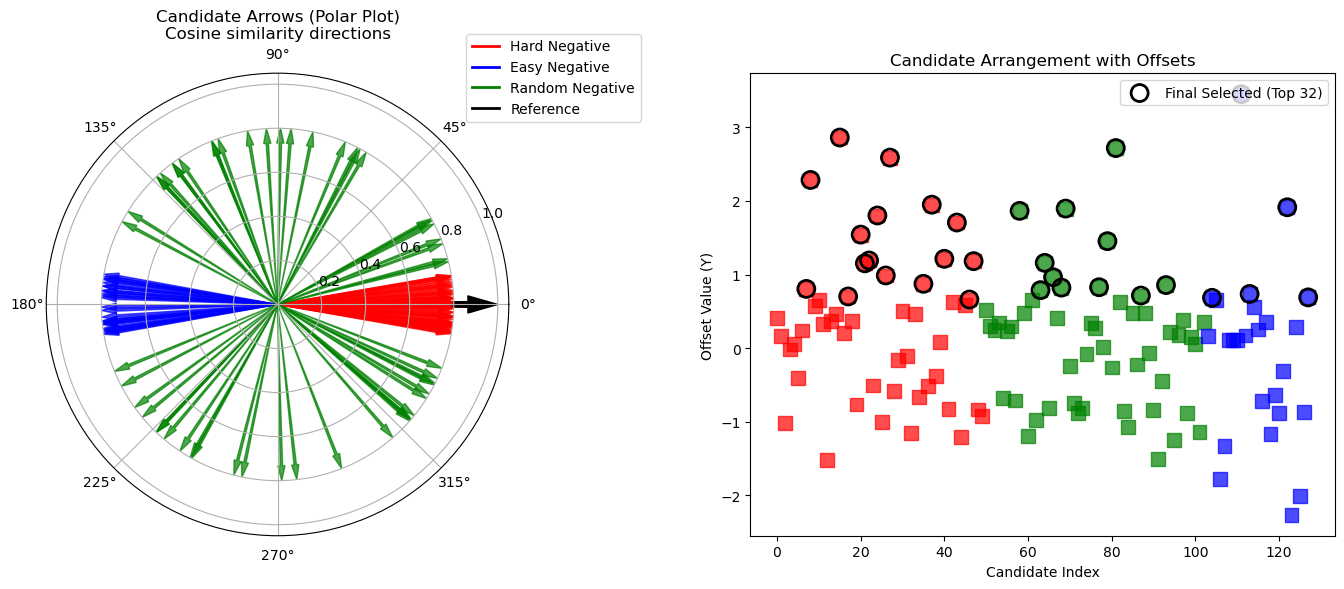

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# 재현성을 위해 랜덤 시드 설정
np.random.seed(42)

n_candidates = 128

##############################
# 1. Polar plot: Candidate arrows (cosine similarity directions)
##############################
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, polar=True)
ax1.set_title("Candidate Arrows (Polar Plot)\nCosine similarity directions", fontsize=12)

# 기준 아이템: 기준 벡터를 0° 방향(오른쪽)으로 표시
ax1.arrow(0, 0, 0, 1.0, width=0.03, color='black',
          label='Reference', length_includes_head=True)

# hard negative: 상위 50개 – 기준과 거의 평행 (-10° ~ 10°)
hard_angles = np.deg2rad(np.random.uniform(-10, 10, 50))
for angle in hard_angles:
    ax1.arrow(angle, 0, 0, 0.8, width=0.015, color='red',
              length_includes_head=True, alpha=0.7)

# easy negative: 하위 25개 – 기준의 반대 방향 근처 (170° ~ 190°)
easy_angles = np.deg2rad(np.random.uniform(170, 190, 25))
for angle in easy_angles:
    ax1.arrow(angle, 0, 0, 0.8, width=0.015, color='blue',
              length_includes_head=True, alpha=0.7)

# random negative: 나머지 53개 – 두 구간에서 생성
# 10°~170°에서 27개, 190°~350°에서 26개
random_angles1 = np.deg2rad(np.random.uniform(10, 170, 27))
random_angles2 = np.deg2rad(np.random.uniform(190, 350, 26))
random_angles = np.concatenate((random_angles1, random_angles2))
for angle in random_angles:
    ax1.arrow(angle, 0, 0, 0.8, width=0.015, color='green',
              length_includes_head=True, alpha=0.7)

# 범례 생성
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Hard Negative'),
    Line2D([0], [0], color='blue', lw=2, label='Easy Negative'),
    Line2D([0], [0], color='green', lw=2, label='Random Negative'),
    Line2D([0], [0], color='black', lw=2, label='Reference')
]
ax1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.1))

##############################
# 2. Linear plot: Candidate ranking with offsets from Normal distributions
##############################
ax2 = fig.add_subplot(122)
ax2.set_title("Candidate Arrangement with Offsets", fontsize=12)
ax2.set_xlabel("Candidate Index")
ax2.set_ylabel("Offset Value (Y)")

# y_vals와 색상을 각 그룹별로 np.random.normal으로 생성
y_vals = np.zeros(n_candidates)
colors = np.empty(n_candidates, dtype='<U10')

# Hard negatives: indices 0 ~ 49, 평균 0.3, 표준편차 1
y_vals[:50] = np.random.normal(0.4, 1, 50)
colors[:50] = 'red'

# Random negatives: indices 50 ~ 102, 평균 0, 표준편차 1 (53개)
y_vals[50:103] = np.random.normal(0, 1, 53)
colors[50:103] = 'green'

# Easy negatives: indices 103 ~ 127, 평균 -0.3, 표준편차 1 (25개)
y_vals[103:128] = np.random.normal(-0.4, 1, 25)
colors[103:128] = 'blue'

indices = np.arange(n_candidates)
# candidate들을 네모(marker='s')로 플롯
ax2.scatter(indices, y_vals, c=colors, s=100, marker='s', alpha=0.7)

# y_vals 기준 내림차순 정렬 후 상위 32개를 최종 선택
sorted_indices = np.argsort(-y_vals)  # 내림차순 정렬
selected = sorted_indices[:32]
ax2.scatter(indices[selected], y_vals[selected],
            facecolors='none', edgecolors='black', s=150, linewidths=2,
            label='Final Selected (Top 32)')

ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
